In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Code Sourced From: lyft3d inference kernel - meaninglesslives
Code Sourced From: nuscenes-devkit by Lyft

In [5]:
!pip install lyft-dataset-sdk

In [7]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

import time
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import os

In [8]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_lidar lidar

In [9]:
# Path to the test data folder
test_data_folder = '/kaggle/input/lyfttestingdata/processedtestdata/bev_test_data'

# Collect file paths for BEV, semantic, and target images
bev_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_bev.png")))
semantic_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_semantic.png")))
target_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_target.png")))

# Check that all file paths are aligned
assert len(bev_filepaths) == len(semantic_filepaths) == len(target_filepaths), "File counts do not match!"

# Print confirmation
print(f"Found {len(bev_filepaths)} BEV files.")
print(f"Found {len(semantic_filepaths)} Semantic files.")
print(f"Found {len(target_filepaths)} Target files.")



Found 27468 BEV files.
Found 27468 Semantic files.
Found 27468 Target files.


Defining the LyftTestDataset - sourced from meanninglesslives and the competition github

In [10]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

Defining the classes present in the dataset

In [11]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
train_dataset = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 14.4 seconds.
Reverse indexing ...
Done reverse indexing in 3.1 seconds.


In [12]:
train_dataset.list_categories()
del train_dataset;

Category stats
animal                      n=  186, width= 0.36±0.12, len= 0.73±0.19, height= 0.51±0.16, lw_aspect= 2.16±0.56
bicycle                     n=20928, width= 0.63±0.24, len= 1.76±0.29, height= 1.44±0.37, lw_aspect= 3.20±1.17
bus                         n= 8729, width= 2.96±0.24, len=12.34±3.41, height= 3.44±0.31, lw_aspect= 4.17±1.10
car                         n=534911, width= 1.93±0.16, len= 4.76±0.53, height= 1.72±0.24, lw_aspect= 2.47±0.22
emergency_vehicle           n=  132, width= 2.45±0.43, len= 6.52±1.44, height= 2.39±0.59, lw_aspect= 2.66±0.28
motorcycle                  n=  818, width= 0.96±0.20, len= 2.35±0.22, height= 1.59±0.16, lw_aspect= 2.53±0.50
other_vehicle               n=33376, width= 2.79±0.30, len= 8.20±1.71, height= 3.23±0.50, lw_aspect= 2.93±0.53
pedestrian                  n=24935, width= 0.77±0.14, len= 0.81±0.17, height= 1.78±0.16, lw_aspect= 1.06±0.20
truck                       n=14164, width= 2.84±0.32, len=10.24±4.09, height= 3.44±0.62, lw_asp

Placing in average heights of the classes.

In [13]:
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
level5data = LyftTestDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/test_data', verbose=True)

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 5.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.9 seconds.


The below code defines functions involving 3D bounding boxes. 
move_boxes_to_car_space transforms the bounding boxes from world to ego vehicle coordinate system.

scale_boxes scales the bounding boxes by the factor defined in the chunk after (.8).

draw_boxes projects the 3D bounding boxes bottom corners onto the 2D (BEV) image and draws boxes

In [14]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [38]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [15]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)

Defining the BEVImageDataset - sourced from meanninglesslives and the competition GitHub

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader
import cv2
import numpy as np

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, bev_filepaths, semantic_filepaths, target_filepaths):
        self.bev_filepaths = bev_filepaths
        self.semantic_filepaths = semantic_filepaths
        self.target_filepaths = target_filepaths

    def __len__(self):
        return len(self.bev_filepaths)

    def __getitem__(self, idx):
        bev_filepath = self.bev_filepaths[idx]
        semantic_filepath = self.semantic_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
    
        sample_token = os.path.basename(bev_filepath).replace("_bev.png", "")

        # Load images
        bev = cv2.imread(bev_filepath, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0  # 3 channels
        semantic = cv2.imread(semantic_filepath, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0  # 1 channel
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0  # 1 channel

        # Add an empty 6th channel (zeros)
        empty_channel = np.zeros_like(target)  # Same size as target (1 channel)

        # Combine into a 6-channel input
        combined_input = np.dstack((bev, semantic, target, empty_channel))  # Shape: (H, W, 6)
        combined_input = torch.from_numpy(combined_input.transpose(2, 0, 1))  # To (C, H, W)

        return combined_input, sample_token




In [17]:
# Initialize test dataset and DataLoader
test_dataset = BEVImageDataset(bev_filepaths, semantic_filepaths, target_filepaths)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


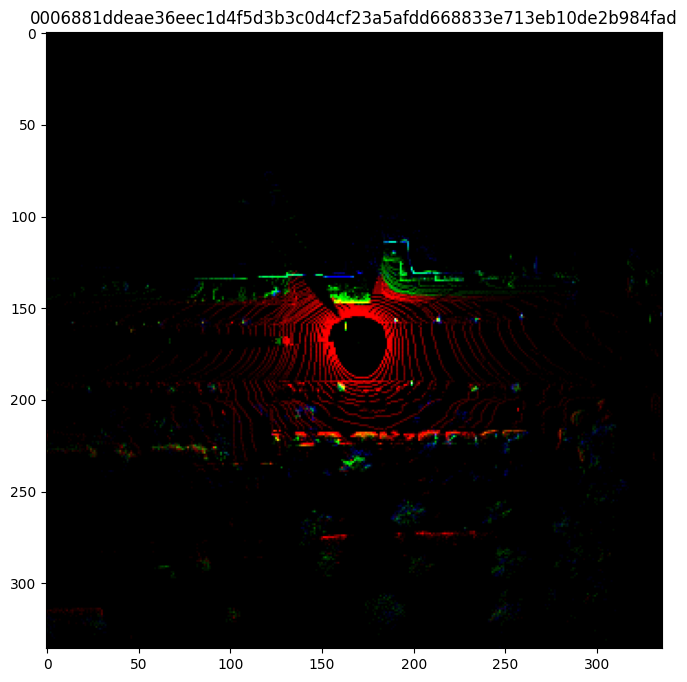

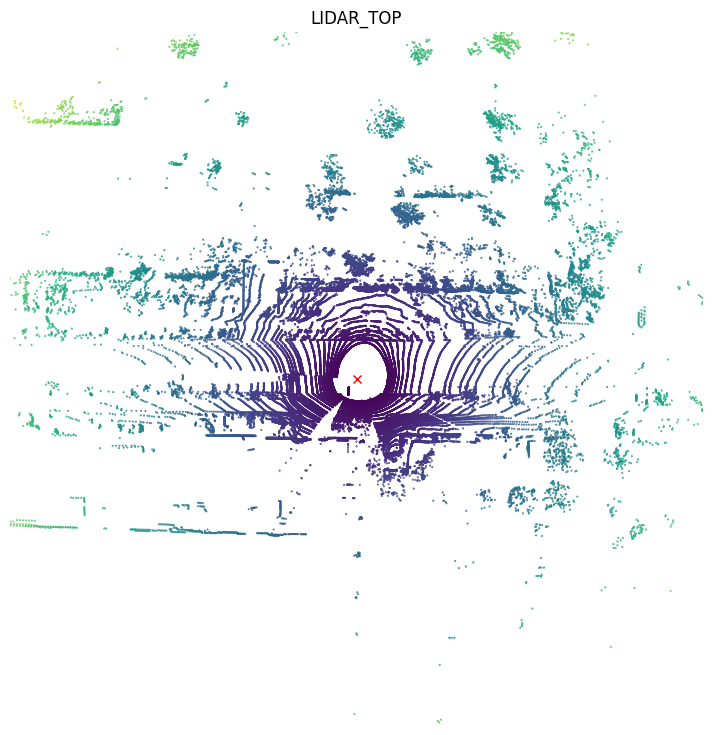

In [18]:
im, sample_token = test_dataset[1]
im = im.numpy()

plt.figure(figsize=(16,8))

# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
# plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.imshow(im.transpose(1,2,0)[...,:3])
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

Defining the UNET class. This is the same code from the CVFinal script.

In [19]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
                                        batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)
        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [20]:
import torch

# Define device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [21]:
# Load the best model saved in CVFinal
BEST_MODEL_PATH = '/kaggle/input/lyfttestingdata/artifacts/kaggle/working/artifacts/unet_best_model.pth'
model = torch.load(BEST_MODEL_PATH, map_location=device)
model = model.to(device)
model.eval()


/tmp/ipykernel_23/3110406922.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(BEST_MODEL_PATH, map_location=device)


DataParallel(
  (module): UNet(
    (down_path): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (2): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
      )
      (3): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(

This function processes prediction masks from the UNET model and generates a 2D bounding box, detection score, and class label. 

In [22]:
def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes

In [23]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

In [24]:
#Running predictions and storing detection boxes, scores, and classes in lists for later export/csv creation

batch_size = 1
import gc
gc.collect()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count()*2)
progress_bar = tqdm_notebook(test_loader)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
# predictions = np.zeros((len(test_loader), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 200

with torch.no_grad():
    model.eval()
    for ii, (X, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = model(X)  # [N, 2, H, W]
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i],
                                                                                              predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_23/202224155.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(test_loader)


  0%|          | 0/27468 [00:00<?, ?it/s]

/tmp/ipykernel_23/1379672768.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_center_index = np.int0(np.mean(box, axis=0))


Total amount of boxes: 8362933


/tmp/ipykernel_23/515600368.py:7: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_pix = np.int0(sample_boxes)


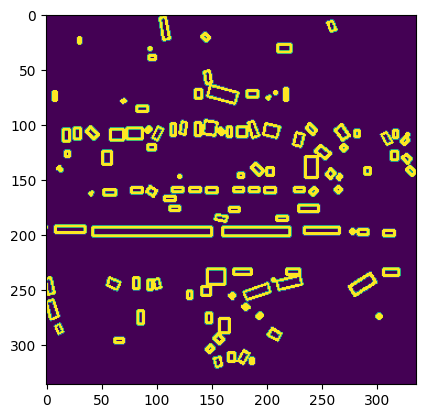

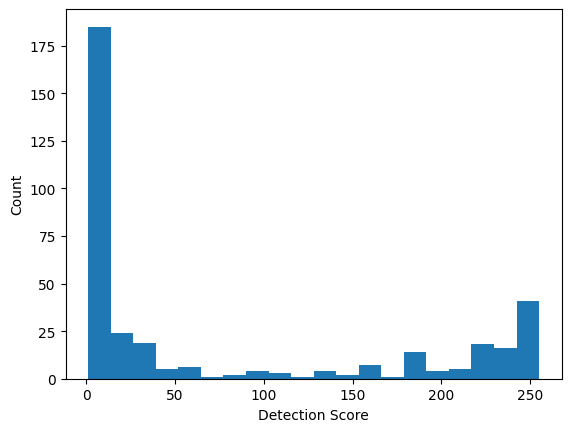

In [25]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

The chunk below defines functions to process 3D point cloud data and converts it to BEV voxel data.

In [36]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

The chunk below was causing session timeouts due to the long runtime. To fix this we added print statements every 1000 samples to produce an output and keep the session active. 

The chunk below processes the 2D detection bounding boxes and transforms them to 3D bounding boxes for submission and evaluation. 

In [39]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D
pred_box3ds = []

# This could use some refactoring..
for idx, (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(
        enumerate(zip(sample_tokens, detection_boxes, detection_scores, detection_classes)), 
        total=len(sample_tokens)):

    # Print progress every 1000 samples
    if idx % 1000 == 0:
        print(f"Processing sample {idx}/{len(sample_tokens)}")

    sample_boxes = sample_boxes.reshape(-1, 2)  # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1, 0)  # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1])))

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)
    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))
    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # Assume all boxes are at the same height as the ego vehicle
    sample_boxes[2, :] = ego_pose["translation"][2]
    sample_boxes = sample_boxes.transpose(1, 0).reshape(-1, 4, 3)

    # Box height
    box_height = np.array([class_heights[cls] for cls in sample_detection_class])

    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:, 2] += box_height / 2

    sample_lengths = np.linalg.norm(sample_boxes[:, 0, :] - sample_boxes[:, 1, :], axis=1) * 1 / box_scale
    sample_widths = np.linalg.norm(sample_boxes[:, 1, :] - sample_boxes[:, 2, :], axis=1) * 1 / box_scale

    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers)
    sample_boxes_dimensions[:, 0] = sample_widths
    sample_boxes_dimensions[:, 1] = sample_lengths
    sample_boxes_dimensions[:, 2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))

        # Determine the rotation of the box
        v = (sample_boxes[i, 0] - sample_boxes[i, 1])
        v /= np.linalg.norm(v)
        r = R.from_matrix([
            [v[0], -v[1], 0],
            [v[1], v[0], 0],
            [0, 0, 1],
        ])
        quat = r.as_quat()
        quat = quat[[3, 0, 1, 2]]  # XYZW -> WXYZ

        detection_score = float(sample_detection_scores[i])

        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)

# Final log
print(f"Finished processing {len(sample_tokens)} samples.")


/tmp/ipykernel_23/3042384253.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(


  0%|          | 0/27468 [00:00<?, ?it/s]

Processing sample 0/27468
Processing sample 1000/27468
Processing sample 2000/27468
Processing sample 3000/27468
Processing sample 4000/27468
Processing sample 5000/27468
Processing sample 6000/27468
Processing sample 7000/27468
Processing sample 8000/27468
Processing sample 9000/27468
Processing sample 10000/27468
Processing sample 11000/27468
Processing sample 12000/27468
Processing sample 13000/27468
Processing sample 14000/27468
Processing sample 15000/27468
Processing sample 16000/27468
Processing sample 17000/27468
Processing sample 18000/27468
Processing sample 19000/27468
Processing sample 20000/27468
Processing sample 21000/27468
Processing sample 22000/27468
Processing sample 23000/27468
Processing sample 24000/27468
Processing sample 25000/27468
Processing sample 26000/27468
Processing sample 27000/27468
Finished processing 27468 samples.


In [40]:
pred_box3ds[0]

{'sample_token': '0005e1fcd0f431ccfc5d301c193da1d1fcd6007c1045669b52327c541fdb6f60', 'translation': [2452.446454565242, 891.3277675394908, -18.799547709406497], 'size': [2.4989734007097133, 1.4999943878163717, 1.72], 'rotation': [0.2712255454293255, 0.0, 0.0, 0.9625158198734007], 'name': 'car', 'volume': 6.447327251351176, 'score': 218.0}

The below chunk takes the data stored in the bounding boxes, scores, and class lists calculated in the previous step and places them in a csv file that follows the competition submission format/requirements. 

In [41]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
#     yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

/tmp/ipykernel_23/1666594049.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(pred_box3ds))):


  0%|          | 0/8362933 [00:00<?, ?it/s]

In [42]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

,Id,PredictionString
0,0005e1fcd0f431ccfc5d301c193da1d1fcd6007c104566...,0.8549019607843137 2452.446454565242 891.32776...
1,0006881ddeae36eec1d4f5d3b3c0d4cf23a5afdd668833...,0.34509803921568627 605.2793129593371 2698.759...
2,000e0f4e29ef684c0a2ccf9bd17586e9b2491e9f488595...,0.7058823529411765 1955.5034424888336 1081.010...
3,0013a4dccf084f18587ad99a20f7c7bc32dc23e10dcd36...,0.8627450980392157 1110.2568099308462 1593.268...
4,0015c9d8d97b2409c6283f7dfa9fdfd1f016ed3146e34d...,0.9921568627450981 1205.0777800750702 1660.653...


In [43]:
sub.to_csv('lyft3d_pred.csv',index=False)

In [ ]:
import shutil
shutil.move("lyft3d_pred.csv", "/kaggle/working/lyft3d_pred.csv")


In [44]:
import zipfile

# Name for the zip file
zip_filename = "lyft3d_pred.zip"
csv_filename = "lyft3d_pred.csv"

# Zip the CSV file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(csv_filename)

print(f"Zipped file created: {zip_filename}")


Zipped file created: lyft3d_pred.zip
